## Recurrent Neural Networks (RNNs)
### and Long Short-Term Memory (LSTM)

In [44]:
import tensorflow as tf
keras = tf.keras
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
import pandas as pd
%matplotlib inline

In [2]:
def windowize_data(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[indices, None]
    return x, y

Then we'll write a function split the data into training and testing sets. Because it's time-series data we have to do that sequentially rather than shuffling it. They should be completely separate and not overlap, so the the training data isn't used for testing.

In [3]:
def split_and_windowize(data, n_prev, fraction_test=0.3):
    n_predictions = len(data) - 2*n_prev
    
    n_test  = int(fraction_test * n_predictions)
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev)
    x_test, y_test = windowize_data(data[n_train:], n_prev)
    return x_train, x_test, y_train, y_test

So this is better.

# Classification

RNNs can also be used for classification. Rather than predicting the next step after a sequence as the output, we predict a class (or rather, a probability). Let's try two sequences, sine waves of slightly difference frequencies.

In [4]:
from keras.datasets import mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()

Using TensorFlow backend.


In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

We don't care about the next value any more.

In [16]:
x_train = x_train[:6000].astype('int32')
x_test = x_test[:1000].astype('int32')

y_train = y_train[:6000].astype('int32')
y_test = y_test[:1000].astype('int32')

In [17]:
y_train.shape
x_train.shape

(6000, 784, 1)

In [18]:
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(y_train).astype('int32')

encoder = LabelEncoder()
encoder.fit(y_test)
encoded_y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(y_test).astype('int32')

In [19]:
n_prev = 784
x_train = np.array([x.flatten().reshape(-1,1) for x in x_train])
x_test = np.array([x.flatten().reshape(-1,1) for x in x_test])

In [20]:
# x_train1, x_test1, _, _ = split_and_windowize(x_train, n_prev)
# x_train1.shape

In [21]:
dummy_y_train.shape

(6000, 10)

Instead, the `y`s are the labels of the class.

We'll use a sigmoid activation at the end.

In [22]:

model = keras.Sequential()
model.add(keras.layers.SimpleRNN(32, input_shape=(n_prev, 1), return_sequences=True))
model.add(keras.layers.LSTM(32, input_shape=(n_prev, 1), return_sequences=True))
model.add(keras.layers.LSTM(32, return_sequences=False))
model.add(keras.layers.Dense(10, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy')

In [23]:
y_train.shape, y_test.shape

((6000,), (1000,))

In [24]:
x_train.shape

(6000, 784, 1)

In [25]:
model.fit(x_train, dummy_y_train, batch_size=32, epochs=5)

Train on 6000 samples
Epoch 1/5
6000/6000 [==============================] - 142s 24ms/sample - loss: 2.0941
Epoch 2/5
6000/6000 [==============================] - 142s 24ms/sample - loss: 1.9367
Epoch 3/5
6000/6000 [==============================] - 139s 23ms/sample - loss: 1.8307
Epoch 4/5
6000/6000 [==============================] - 139s 23ms/sample - loss: 1.7433
Epoch 5/5
6000/6000 [==============================] - 140s 23ms/sample - loss: 1.5264


In [26]:
y_pred_prob = model.predict(x_test.astype('float32'))

In [27]:
def get_prediction(y):
    return np.argmax(y)

In [28]:
y_pred = np.array([get_prediction(y) for y in y_pred_prob])

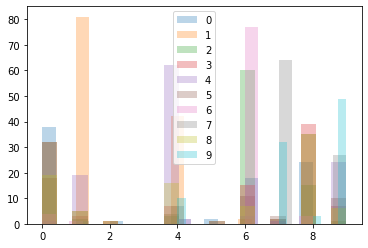

In [29]:
fix, ax = plt.subplots()
ax.hist(y_pred[y_test == 0], alpha=0.3, bins=20, label="0")
ax.hist(y_pred[y_test == 1], alpha=0.3, bins=20, label="1")
ax.hist(y_pred[y_test == 2], alpha=0.3, bins=20, label="2")
ax.hist(y_pred[y_test == 3], alpha=0.3, bins=20, label="3")
ax.hist(y_pred[y_test == 4], alpha=0.3, bins=20, label="4")
ax.hist(y_pred[y_test == 5], alpha=0.3, bins=20, label="5")
ax.hist(y_pred[y_test == 6], alpha=0.3, bins=20, label="6")
ax.hist(y_pred[y_test == 7], alpha=0.3, bins=20, label="7")
ax.hist(y_pred[y_test == 8], alpha=0.3, bins=20, label="8")
ax.hist(y_pred[y_test == 9], alpha=0.3, bins=20, label="9")
ax.legend()

In [35]:
df = pd.DataFrame(y_test)
df.columns = ['actual']
df['predict']=y_pred

In [39]:
df['match']=(df['actual']==df['predict'])*1

In [40]:
df

,actual,predict,match
0,7,7,1
1,2,6,0
2,1,1,1
3,0,0,1
4,4,4,1
...,...,...,...
995,2,6,0
996,2,6,0
997,0,0,1
998,8,0,0


In [42]:
df['match'].value_counts()

0    594
1    406
Name: match, dtype: int64

In [58]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dense(64, activation='relu'))
conv_model.add(layers.Dense(10, activation='softmax'))
conv_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [64]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()

x_train = np.array([x.reshape(28,28,1) for x in x_train])
x_test = np.array([x.reshape(28,28,1) for x in x_test])
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(y_train).astype('int32')

encoder = LabelEncoder()
encoder.fit(y_test)
encoded_y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(y_test).astype('int32')
conv_model.fit(x_train, dummy_y_train, batch_size=32, epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 37s 622us/sample - loss: 0.0351 - accuracy: 0.9891
Epoch 2/10
60000/60000 [==============================] - 37s 621us/sample - loss: 0.0297 - accuracy: 0.9911
Epoch 3/10
60000/60000 [==============================] - 37s 622us/sample - loss: 0.0291 - accuracy: 0.9911
Epoch 4/10
60000/60000 [==============================] - 38s 626us/sample - loss: 0.0228 - accuracy: 0.9929
Epoch 5/10
60000/60000 [==============================] - 38s 627us/sample - loss: 0.0225 - accuracy: 0.9935
Epoch 6/10
60000/60000 [==============================] - 38s 628us/sample - loss: 0.0228 - accuracy: 0.9936
Epoch 7/10
60000/60000 [==============================] - 38s 635us/sample - loss: 0.0198 - accuracy: 0.9946
Epoch 8/10
60000/60000 [==============================] - 38s 634us/sample - loss: 0.0195 - accuracy: 0.9947
Epoch 9/10
60000/60000 [==============================] - 38s 636us/sample - loss: 0.0187 - accuracy: 0.9

In [65]:
y_pred_prob = conv_model.predict(x_test.astype('float32'))
y_pred = np.array([get_prediction(y) for y in y_pred_prob])

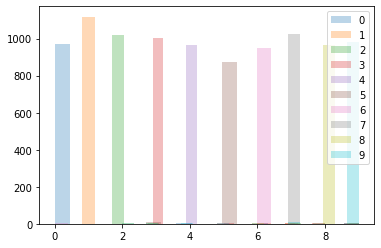

In [66]:
fix, ax = plt.subplots()
ax.hist(y_pred[y_test == 0], alpha=0.3, bins=20, label="0")
ax.hist(y_pred[y_test == 1], alpha=0.3, bins=20, label="1")
ax.hist(y_pred[y_test == 2], alpha=0.3, bins=20, label="2")
ax.hist(y_pred[y_test == 3], alpha=0.3, bins=20, label="3")
ax.hist(y_pred[y_test == 4], alpha=0.3, bins=20, label="4")
ax.hist(y_pred[y_test == 5], alpha=0.3, bins=20, label="5")
ax.hist(y_pred[y_test == 6], alpha=0.3, bins=20, label="6")
ax.hist(y_pred[y_test == 7], alpha=0.3, bins=20, label="7")
ax.hist(y_pred[y_test == 8], alpha=0.3, bins=20, label="8")
ax.hist(y_pred[y_test == 9], alpha=0.3, bins=20, label="9")
ax.legend()